Install all the dependencies

In [1]:
!pip install pinecone sentence-transformers langchain-pinecone langchain langgraph langchain-google-vertexai langchain-huggingface pandas --quiet

Import all the dependencies

In [2]:
import os
import time
import json
import pandas as pd
from typing import Dict, Any

from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore
from langgraph.graph import StateGraph, END
from langchain_google_vertexai import VertexAIEmbeddings, VertexAI
from google import genai
from google.genai.types import HttpOptions

from dotenv import load_dotenv
load_dotenv()

/home/zadmin/genai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zadmin/genai/lib/python3.11/site-packages/langchain_pinecone/__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_pinecone.vectorstores import Pinecone, PineconeVectorStore


True

In [3]:
# Load Dataset

with open("self_critique_loop_dataset.json", "r") as f:
    kb_data = json.load(f)

print("Loaded KB entries:", len(kb_data))
pd.DataFrame(kb_data).head()


Loaded KB entries: 30


,doc_id,question,answer_snippet,source,confidence_indicator,last_updated
0,KB001,What are best practices for debugging?,"When addressing debugging, it's important to f...",debugging_guide.md,moderate,2024-01-10
1,KB002,What are best practices for performance tuning?,"When addressing performance tuning, it's impor...",performance tuning_guide.md,moderate,2024-02-10
2,KB003,What are best practices for caching?,"When addressing caching, it's important to fol...",caching_guide.md,moderate,2024-03-10
3,KB004,What are best practices for asynchronous progr...,"When addressing asynchronous programming, it's...",asynchronous programming_guide.md,moderate,2024-04-10
4,KB005,What are best practices for API versioning?,"When addressing API versioning, it's important...",API versioning_guide.md,moderate,2024-05-10


In [4]:
# if you have already added API key to env file, then this cell is not needed

os.environ['PINECONE_API_KEY'] = "pcsk_23rEUe_E7CHN2368jN9x1dE8k4sac9kX6UPQ4h1tLTbBV8HfEXW6DJCVFzKLfKMMdfWcTM"

In [5]:
# Embeddings & Pinecone Indexing referred from Assignment3_pinecone_quickstart_guide.ipynb

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
if not PINECONE_API_KEY:
    raise RuntimeError("PINECONE_API_KEY not found. Please set it in your environment.")
else:
  print("PINECONE API KEY found")

pc = Pinecone(api_key=PINECONE_API_KEY)

PINECONE API KEY found


In [6]:
# pc.delete_index("assignment3-shivam")

In [7]:
pc.list_indexes()

[
    {
        "name": "assignment3-shivam",
        "metric": "cosine",
        "host": "assignment3-shivam-dqz56te.svc.aped-4627-b74a.pinecone.io",
        "spec": {
            "serverless": {
                "cloud": "aws",
                "region": "us-east-1"
            }
        },
        "status": {
            "ready": true,
            "state": "Ready"
        },
        "vector_type": "dense",
        "dimension": 3072,
        "deletion_protection": "disabled",
        "tags": null
    },
    {
        "name": "tredenceb3",
        "metric": "cosine",
        "host": "tredenceb3-dqz56te.svc.aped-4627-b74a.pinecone.io",
        "spec": {
            "serverless": {
                "cloud": "aws",
                "region": "us-east-1"
            }
        },
        "status": {
            "ready": true,
            "state": "Ready"
        },
        "vector_type": "dense",
        "dimension": 384,
        "deletion_protection": "disabled",
        "tags": null
    }
]

In [8]:
existing_indexes = [idx["name"] for idx in pc.list_indexes()]
existing_indexes

['assignment3-shivam', 'tredenceb3']

In [9]:
INDEX_NAME = "assignment3-shivam"

existing_indexes = [idx["name"] for idx in pc.list_indexes()]

# Embeddings
# embedding_model = VertexAIEmbeddings(model_name="gemini-embedding-001")
# pip install -U langchain-google-vertexai

embedding_model = VertexAIEmbeddings(model_name="gemini-embedding-001")

# Dynamically detect embedding dimension
VECTOR_DIM = len(embedding_model.embed_query("dimension probe"))
print(f"Embedding dimension detected: {VECTOR_DIM}")

if INDEX_NAME not in existing_indexes:
    pc.create_index(
        name=INDEX_NAME,
        dimension=VECTOR_DIM,
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )
    print(f"Index '{INDEX_NAME}' created.")
else:
    print(f"Index '{INDEX_NAME}' already exists, reusing it.")

# Prepare texts & metadata
texts, metadatas, ids = [], [], []
for entry in kb_data:
    text = entry.get("answer_snippet") or entry.get("text") or entry.get("question","")
    doc_id = entry.get("doc_id") or entry.get("id") or f"KB_{len(ids)+1}"
    meta = {
        "doc_id": doc_id,
        "question": entry.get("question",""),
        "source": entry.get("source",""),
        "last_updated": entry.get("last_updated","")
    }
    texts.append(text)
    metadatas.append(meta)
    ids.append(doc_id)

# Vectorstore (LangChain-Pinecone wrapper from quickstart)
vectorstore = PineconeVectorStore(
    index_name=INDEX_NAME,
    embedding=embedding_model,
    namespace=None,
    pinecone_api_key=PINECONE_API_KEY,
)

# Upsert KB
vectorstore.add_texts(texts=texts, metadatas=metadatas, ids=ids)
print(f"Upserted {len(ids)} docs into Pinecone index {INDEX_NAME}")


/home/zadmin/genai/lib/python3.11/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


Embedding dimension detected: 3072
Index 'assignment3-shivam' already exists, reusing it.
Upserted 30 docs into Pinecone index assignment3-shivam


In [ ]:
# List available models in this project/region and pick the best "Gemini 1.5" variant if present.

client = genai.Client(http_options=HttpOptions(api_version="v1"))
available_models = [m.name for m in client.models.list()]
print("Available models (sample):")
for m in available_models:
    print("-", m)

# Assignment requests Gemini 1.5 -> prefer exact gemini-1.5 if present, otherwise pro/flash previews, otherwise gemini-pro
if any(m == "gemini-1.5" for m in available_models):
    DEFAULT_MODEL = "gemini-1.5"
elif any("gemini-1.5-pro" in m for m in available_models):
    DEFAULT_MODEL = [m for m in available_models if "gemini-1.5-pro" in m][0]  # pick matching name
elif any("gemini-1.5-flash" in m for m in available_models):
    DEFAULT_MODEL = [m for m in available_models if "gemini-1.5-flash" in m][0]
elif any("gemini-pro" in m for m in available_models):
    DEFAULT_MODEL = [m for m in available_models if "gemini-pro" in m][0]
else:
    # if nothing found, raise so user configures model availability
    print("No Gemini 1.5 / Gemini Pro model found in this environment. Please enable a model.")
print("\nUsing model:", DEFAULT_MODEL)


Available models (sample):
- models/gemini-2.5-flash
- models/gemini-2.5-pro
- models/gemini-2.0-flash
- models/gemini-2.0-flash-001
- models/gemini-2.0-flash-lite-001
- models/gemini-2.0-flash-lite
- models/gemini-2.0-flash-preview-image-generation
- models/gemini-2.5-flash-lite
- models/embedding-001
- models/text-embedding-004


RuntimeError: No Gemini 1.5 / Gemini Pro model found in this environment. Please enable a model.

In [11]:
# LangGraph Workflow

llm = VertexAI(model="gemini-2.5-flash", temperature=0)

class RAGState(Dict[str, Any]):
    question: str
    retrieved_docs: list
    answer: str
    critique: str

# Phase 1: Retrieve
def retrieve_kb(state: RAGState):
    docs = vectorstore.similarity_search(state["question"], k=5)
    state["retrieved_docs"] = [d.page_content for d in docs]
    return state

# Phase 2: Generate
def generate_answer(state: RAGState):
    context = "\n".join(state["retrieved_docs"])
    prompt = f"""
    Question: {state['question']}
    Context (KB): {context}
    Provide an answer citing doc_ids as [KBxxx].
    """
    state["answer"] = llm(prompt)
    return state

# Phase 3: Critique
def critique_answer(state: RAGState):
    prompt = f"""
    Review this answer:
    {state['answer']}
    Decide if it's COMPLETE or needs refinement.
    Respond with either:
    COMPLETE
    REFINE: <keywords>
    """
    state["critique"] = llm(prompt)
    return state

# Phase 4: Refine
def refine_answer(state: RAGState):
    if state["critique"].startswith("REFINE"):
        keywords = state["critique"].replace("REFINE:", "").strip()
        docs = vectorstore.similarity_search(keywords, k=1)
        if docs:
            state["retrieved_docs"].append(docs[0].page_content)
        context = "\n".join(state["retrieved_docs"])
        prompt = f"""
        Question: {state['question']}
        Context (KB): {context}
        Provide a refined answer citing doc_ids as [KBxxx].
        """
        state["answer"] = llm(prompt)
    return state


In [12]:
# Create LangGraph

graph = StateGraph(RAGState)

graph.add_node("retrieve_kb", retrieve_kb)
graph.add_node("generate_answer", generate_answer)
graph.add_node("critique_answer", critique_answer)
graph.add_node("refine_answer", refine_answer)

graph.set_entry_point("retrieve_kb")
graph.add_edge("retrieve_kb", "generate_answer")
graph.add_edge("generate_answer", "critique_answer")

def critique_condition(state: RAGState):
    return "refine_answer" if state["critique"].startswith("REFINE") else END

graph.add_conditional_edges("critique_answer", critique_condition)
graph.add_edge("refine_answer", END)

compiled_graph = graph.compile()


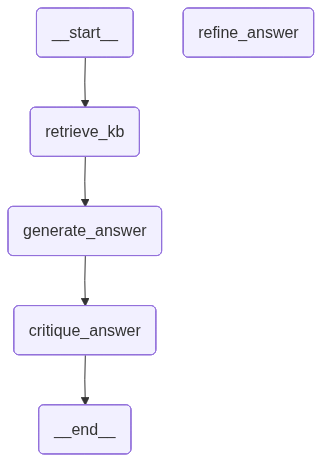

In [16]:
compiled_graph

In [13]:
# Test Queries

test_queries = [
    "What are best practices for caching?",
    "How should I set up CI/CD pipelines?",
    "What are performance tuning tips?",
    "How do I version my APIs?",
    "What should I consider for error handling?"
]

results = []
for q in test_queries:
    final_state = compiled_graph.invoke({"question": q})
    results.append({
        "question": q,
        "answer": final_state["answer"],
        "critique": final_state["critique"]
    })

results_df = pd.DataFrame(results)


/tmp/ipykernel_9203/1710512451.py:25: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  state["answer"] = llm(prompt)


In [14]:
results_df

,question,answer,critique
0,What are best practices for caching?,"When addressing caching, it's important to fol...","REFINE: Caching patterns (e.g., Cache-Aside, R..."
1,How should I set up CI/CD pipelines?,"When setting up CI/CD pipelines, it's importan...","REFINE: specificity, benefits, examples"
2,What are performance tuning tips?,"When addressing performance tuning, it's impor...",COMPLETE
3,How do I version my APIs?,"To version your APIs, it's important to follow...","REFINE: API versioning patterns, URL versionin..."
4,What should I consider for error handling?,"When considering error handling, it's importan...","REFINE: `justification`, `specificity of patte..."


In [15]:
# Save results
results_df.to_csv("assignment3_results.csv", index=False)
print("Results saved to assignment3_results.csv")

Results saved to assignment3_results.csv
